In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchaudio
import torchaudio.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models
import numpy as np
from torch.utils.data import random_split,Dataset,DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset = ImageFolder('/content/drive/MyDrive/praca_inzynierska/data/SPECTROGRAMS')

In [ ]:
len(dataset)

1102

In [ ]:
genres = []
for i in dataset.classes:
  genres.append(i)
genres

['CLASSICAL',
 'DISCO',
 'EDM',
 'FUNK',
 'HEAVY_METAL',
 'HIP-HOP',
 'JAZZ',
 'POP',
 'REGGAE',
 'ROCK',
 'TECHNO']

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(len(dataset)*val_pct)
train_size = dataset_size - val_size
train_size,test_size,val_size

(772, 220, 110)

In [ ]:
train_ds,test_ds,val_ds = random_split(dataset,[train_size,test_size,val_size])
len(train_ds),len(test_ds),len(val_ds)

(772, 220, 110)

TECHNO
<class 'PIL.Image.Image'>
Image width: 432, Image height: 288


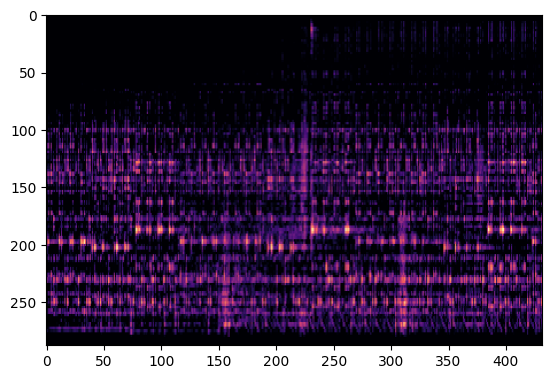

In [ ]:
img,label = train_ds[2]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))
width, height = img.size

# Print the image size
print(f"Image width: {width}, Image height: {height}")

In [ ]:
class MusicGenreDataset(Dataset):
  def __init__(self,ds,transform=None):
    self.ds = ds
    self.transform = transform

  def __len__(self):
    return len(self.ds)

  def __getitem__(self,idx):
    img,label = self.ds[idx]
    if self.transform:
      img = self.transform(img)
      return img,label

In [ ]:
train_transform = transforms.Compose([
#     transforms.Resize((224,224)),
    # transforms.RandomCrop(224, padding=4,padding_mode='reflect'),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomRotation(degrees=30),
    # transforms.GaussianBlur(kernel_size = 7,sigma = (0.1, 2.0)),
    # transforms.ElasticTransform(alpha=50.0),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
#     transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
#     transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = MusicGenreDataset(train_ds,train_transform)
val_dataset = MusicGenreDataset(val_ds,val_transform)
test_dataset = MusicGenreDataset(test_ds,test_transform)

EDM


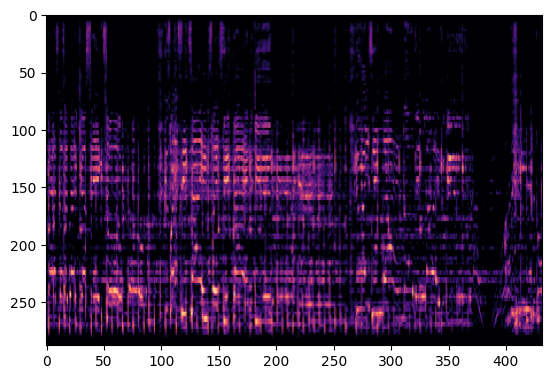

In [ ]:
img, label = train_dataset[10]
print(dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size = 5
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size*2,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size*2,num_workers=2,pin_memory=True)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


In [ ]:
import torch.nn as nn

class MusicGenreClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),

            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),


            nn.Flatten(),
            nn.Linear(54*36*256, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.Dropout(p=0.3, inplace=False),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
model = MusicGenreClassificationCNN()
model

MusicGenreClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1

In [ ]:
class MusicGenrePretrainedResnet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = MusicGenrePretrainedResnet50()
model2

MusicGenrePretrainedResnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [ ]:
class MusicGenrePretrainedInceptionV3(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model3 = MusicGenrePretrainedInceptionV3()
model3

MusicGenrePretrainedInceptionV3(
  (network): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    

In [ ]:
class MusicGenrePretrainedVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16('VGG16_Weights.DEFAULT')
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=120, bias=True),
           nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model4 = MusicGenrePretrainedVGG16()
model4

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


MusicGenrePretrainedVGG16(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

In [ ]:
class MusicGenrePretrainedGoogleNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.googlenet(weights = 'GoogLeNet_Weights.DEFAULT')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model5 = MusicGenrePretrainedGoogleNet()
model5

MusicGenrePretrainedGoogleNet(
  (network): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=

In [ ]:
class MusicGenrePretrainedResnet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet152(weights = 'ResNet152_Weights.DEFAULT')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model6 = MusicGenrePretrainedResnet152()
model6

MusicGenrePretrainedResnet152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [ ]:
class MusicGenrePretrainedDenseNet169(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.densenet169(weights = 'DenseNet169_Weights.DEFAULT')
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model7 = MusicGenrePretrainedDenseNet169()
model7

MusicGenrePretrainedDenseNet169(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96,

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class MusicGenrePretrainedDenseNet201(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.densenet201(weights = 'DenseNet201_Weights.IMAGENET1K_V1')
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model8 = MusicGenrePretrainedDenseNet201()
model8

MusicGenrePretrainedDenseNet201(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96,

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model8, device);

cuda


In [ ]:
def proc_time(b_sz, model, n_iter=10):
    x = torch.rand(b_sz, 3, 432, 288).cuda()
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_iter):
        model(x)
    torch.cuda.synchronize()
    end = time.time() - start
    throughput = b_sz * n_iter / end
    print(f"Batch: {b_sz} \t {throughput} samples/sec")
    return (b_sz, throughput, )

In [ ]:
# proc_time(10,model3)

In [ ]:
# # check the model
# def try_batch(dl):
#     for imgs, labels in dl:
#         print("images shape : ", imgs.shape)
#         print("labels : ", labels)
#         outs = model(imgs)
#         print("outs.shape :", outs.shape)
#         print("outs : ", outs)
#         break

# try_batch(train_dl)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    best_metric = float('0')
    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        # Check if the current validation metric is better than the best one
        current_metric = result['val_acc']
        if current_metric > best_metric:
            best_metric = current_metric

            # Save the best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_metric': best_metric
            }, 'best_DenseNet169_checkpoint.pth')
            print(f'saved a model with accuracy: {result["val_acc"]}')


    return history



@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
evaluate(model8, val_dl)

{'val_loss': 4.736279487609863, 'val_acc': 0.04545454680919647}

In [ ]:
num_epochs = 35
opt_func = torch.optim.SGD

max_lr = 0.00025
grad_clip = 0.1
weight_decay = 1.5e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model8, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [0] : train_loss: 4.5593, val_loss: 4.2278, val_acc: 0.1000
saved a model with accuracy: 0.10000000149011612


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1] : train_loss: 3.8293, val_loss: 3.3176, val_acc: 0.2909
saved a model with accuracy: 0.290909081697464


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2] : train_loss: 3.0194, val_loss: 2.5215, val_acc: 0.3909
saved a model with accuracy: 0.3909090757369995


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3] : train_loss: 2.5028, val_loss: 2.1219, val_acc: 0.4545
saved a model with accuracy: 0.4545454680919647


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [4] : train_loss: 2.1672, val_loss: 1.8797, val_acc: 0.4818
saved a model with accuracy: 0.48181819915771484


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.9294, val_loss: 1.6360, val_acc: 0.4818


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.8043, val_loss: 1.5176, val_acc: 0.5545
saved a model with accuracy: 0.5545454621315002


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.6596, val_loss: 1.4812, val_acc: 0.5545


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.5219, val_loss: 1.3388, val_acc: 0.6091
saved a model with accuracy: 0.6090909242630005


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.4802, val_loss: 1.3353, val_acc: 0.6455
saved a model with accuracy: 0.6454545259475708


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [10] : train_loss: 1.3085, val_loss: 1.2388, val_acc: 0.6182


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [11] : train_loss: 1.2081, val_loss: 1.1561, val_acc: 0.6091


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [12] : train_loss: 1.0714, val_loss: 1.1482, val_acc: 0.6091


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [13] : train_loss: 1.0326, val_loss: 1.0632, val_acc: 0.6636
saved a model with accuracy: 0.663636326789856


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [14] : train_loss: 0.9477, val_loss: 1.0043, val_acc: 0.7000
saved a model with accuracy: 0.699999988079071


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [15] : train_loss: 0.8621, val_loss: 1.0365, val_acc: 0.6545


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [16] : train_loss: 0.7567, val_loss: 0.9808, val_acc: 0.7091
saved a model with accuracy: 0.7090909481048584


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [17] : train_loss: 0.6742, val_loss: 0.9499, val_acc: 0.7000


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [18] : train_loss: 0.6236, val_loss: 0.9183, val_acc: 0.7091


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [19] : train_loss: 0.5502, val_loss: 0.8508, val_acc: 0.7091


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [20] : train_loss: 0.4991, val_loss: 0.9097, val_acc: 0.7273
saved a model with accuracy: 0.7272728085517883


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [21] : train_loss: 0.4080, val_loss: 0.8649, val_acc: 0.7182


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [22] : train_loss: 0.3565, val_loss: 0.8941, val_acc: 0.7273


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [23] : train_loss: 0.3484, val_loss: 0.8972, val_acc: 0.7545
saved a model with accuracy: 0.7545454502105713


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [24] : train_loss: 0.3312, val_loss: 0.8829, val_acc: 0.7273


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [25] : train_loss: 0.2821, val_loss: 0.8845, val_acc: 0.7364


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [26] : train_loss: 0.2664, val_loss: 0.8704, val_acc: 0.7273


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [27] : train_loss: 0.2258, val_loss: 0.9321, val_acc: 0.7000


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [28] : train_loss: 0.2100, val_loss: 0.9300, val_acc: 0.6818


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [29] : train_loss: 0.2041, val_loss: 0.9245, val_acc: 0.7182


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [30] : train_loss: 0.2100, val_loss: 0.8941, val_acc: 0.7182


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [31] : train_loss: 0.2238, val_loss: 0.8680, val_acc: 0.7273


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [32] : train_loss: 0.1936, val_loss: 0.9349, val_acc: 0.7000


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [33] : train_loss: 0.1702, val_loss: 0.9085, val_acc: 0.7182


  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [34] : train_loss: 0.1852, val_loss: 0.9314, val_acc: 0.7273


In [ ]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

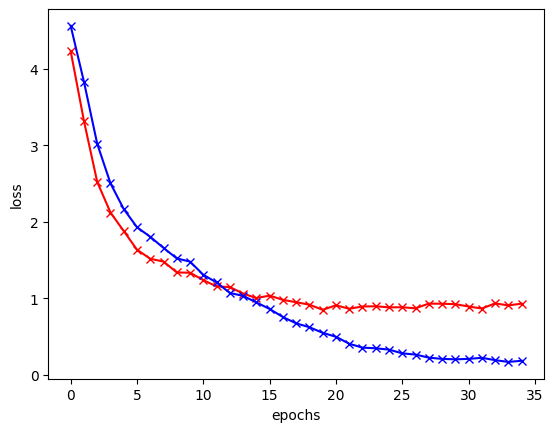

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

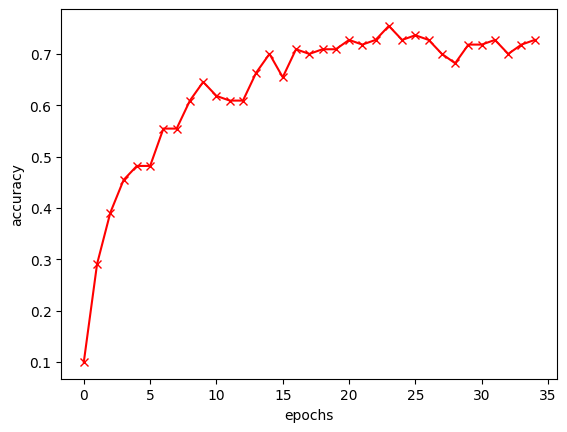

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()